In [242]:
import pynapple as nap
import numpy as np
import matplotlib.pyplot as plt

import os
from os.path import dirname, join as pjoin
import scipy.io as sio

import pymatreader

import pandas as pd

import random
import matplotlib as mpl

In [491]:
data_dir = pjoin('C:\\Users\\Acer\\Documents\\compNeuroProjects\\neural_reco_offline\\Duszkiewicz2024', 'Dataset_2', 'A3709-200601', 'Data')
spikeData_fname = pjoin(data_dir, 'SpikeData.mat')
velocity_fname = pjoin(data_dir, 'Velocity.mat')
behav_epochs_fname = pjoin(data_dir, 'BehavEpochs.mat')
angle_fname = pjoin(data_dir, 'Angle.mat')
epoch_ts_fname = pjoin(data_dir, 'Epoch_TS.csv')
tracking_fname = pjoin(data_dir, "Tracking_data.csv")



In [492]:
os.listdir(data_dir)

['._Ahv.mat',
 '._Angle.mat',
 '._BehavEpochs.mat',
 '._BrainArea.mat',
 '._CellDepth.mat',
 '._CellTypes.mat',
 '._Epoch_TS.csv',
 '._SpikeData.mat',
 '._Tracking_data.csv',
 '._Velocity.mat',
 '._WaveformFeatures.mat',
 '._Waveforms.mat',
 'Ahv.mat',
 'Angle.mat',
 'BehavEpochs.mat',
 'BrainArea.mat',
 'CellDepth.mat',
 'CellTypes.mat',
 'Epoch_TS.csv',
 'SpikeData.mat',
 'Tracking_data.csv',
 'Velocity.mat',
 'WaveformFeatures.mat',
 'Waveforms.mat']

In [493]:
spikeData = pymatreader.read_mat(spikeData_fname)
# velocity = pymatreader.read_mat(velocity_fname)
behav_epochs = pymatreader.read_mat(behav_epochs_fname)
angleData = pymatreader.read_mat(angle_fname)

print(behav_epochs.keys())
print(spikeData.keys())
# print(velocity.keys())
print(angleData.keys())



dict_keys(['__header__', '__version__', '__globals__', 'sleep1Ep', 'sleep1Ep_Info', 'wake1Ep', 'wake1Ep_Info', 'sleep2Ep', 'sleep2Ep_Info', 'wake2Ep', 'wake2Ep_Info'])
dict_keys(['__header__', '__version__', '__globals__', 'S', 'S_Info', 'shank', 'shank_Info', 'cellIx', 'cellIx_Info'])
dict_keys(['__header__', '__version__', '__globals__', 'ang', 'ang_Info'])


In [495]:
tracking_data = pd.read_csv(tracking_fname)
epoch_ts = pd.read_csv(epoch_ts_fname)

In [496]:
head_direction = nap.Tsd(

    t = angleData['ang']['t'],
    d = angleData['ang']['data']
    )

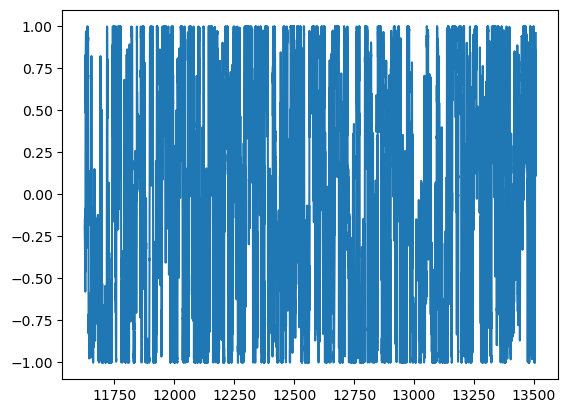

In [497]:
time_hd = angleData['ang']['t']
hd = angleData['ang']['data']
plt.plot(time_hd, np.sin(hd))
# plt.plot(time_hd, hd)
ax = plt.gca()
# ax.set_xlim([6000,6250])

# plt.figure()
# plt.hist(np.tan(hd[:-1])-np.tan(hd[1:]))


In [498]:
behav_epochs

{'__header__': b'MATLAB 5.0 MAT-file, Platform: PCWIN64, Created on: Mon Jun  1 19:28:59 2020',
 '__version__': '1.0',
 '__globals__': [],
 'sleep1Ep': {'units': {'quantity': 'time', 'unit': 'ts', 'value': 1},
  'start': 5e-05,
  'stop': 11622.38},
 'sleep1Ep_Info': 'No info',
 'wake1Ep': {'units': {'quantity': 'time', 'unit': 'ts', 'value': 1},
  'start': 11622.38,
  'stop': 13507.99},
 'wake1Ep_Info': 'No info',
 'sleep2Ep': {'units': {'quantity': 'time', 'unit': 'ts', 'value': 1},
  'start': array([], dtype=uint8),
  'stop': array([], dtype=uint8)},
 'sleep2Ep_Info': 'No info',
 'wake2Ep': {'units': {'quantity': 'time', 'unit': 'ts', 'value': 1},
  'start': array([], dtype=uint8),
  'stop': array([], dtype=uint8)},
 'wake2Ep_Info': 'No info'}

In [416]:
# behav_epochs['wake1Ep']['start']

In [500]:
wake_epochs = nap.IntervalSet(start=[behav_epochs['wake1Ep']['start']], end=[behav_epochs['wake1Ep']['stop']])
# wake_epochs = nap.IntervalSet(start=[behav_epochs['wake1Ep']['start'], behav_epochs['wake2Ep']['start']], end=[behav_epochs['wake1Ep']['stop'], behav_epochs['wake2Ep']['stop']])
# sleep_epochs = nap.IntervalSet(start=[behav_epochs['sleep1Ep']['start'], behav_epochs['sleep2Ep']['start']], end=[behav_epochs['sleep1Ep']['stop'], behav_epochs['sleep2Ep']['stop']])
wake_epochs

  index    start    end
      0  11622.4  13508
shape: (1, 2), time unit: sec.

In [501]:

art_epoch_per = 200
num_art_epochs = int((wake_epochs[0]['end'] - wake_epochs[0]['start'])/art_epoch_per)
print(num_art_epochs)
l_start = []
l_end = []

for i in range(num_art_epochs):
    start = wake_epochs[0]['start'] + i*art_epoch_per
    l_start.append(start)
    end = wake_epochs[0]['start'] + (i+1)*art_epoch_per
    l_end.append(end)
    print('start: ', start, 'end:', end)



# art_epoch_per = 200
# num_art_epochs = int((wake_epochs[1]['end'] - wake_epochs[1]['start'])/art_epoch_per)
# print(num_art_epochs)
# for i in range(num_art_epochs):
#     start = wake_epochs[1]['start'] + i*art_epoch_per
#     l_start.append(start)
#     end = wake_epochs[1]['start'] + (i+1)*art_epoch_per
#     l_end.append(end)
#     print('start: ', start, 'end:', end)


arbitrary_epochs = nap.IntervalSet(start=l_start[0], end=l_end[0])

9
start:  [11622.38] end: [11822.38]
start:  [11822.38] end: [12022.38]
start:  [12022.38] end: [12222.38]
start:  [12222.38] end: [12422.38]
start:  [12422.38] end: [12622.38]
start:  [12622.38] end: [12822.38]
start:  [12822.38] end: [13022.38]
start:  [13022.38] end: [13222.38]
start:  [13222.38] end: [13422.38]


C:\Users\Acer\AppData\Local\Temp\ipykernel_11332\2342554314.py:2: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  num_art_epochs = int((wake_epochs[0]['end'] - wake_epochs[0]['start'])/art_epoch_per)


In [502]:
spikeData.keys()

dict_keys(['__header__', '__version__', '__globals__', 'S', 'S_Info', 'shank', 'shank_Info', 'cellIx', 'cellIx_Info'])

In [503]:
sp_times = spikeData["S"]['C']
cell_ids = spikeData["cellIx"]
len(sp_times) == len(cell_ids)

True

In [507]:
len(cell_ids)
len(l_cellids)

64

In [505]:
l_cellids = []
for i in range(len(cell_ids)):
    if (type(sp_times[i]['tsd']['t']) == type(np.arange(10))) and (len(sp_times[i]['tsd']['t']) > 1000):
        l_cellids.append(cell_ids[i])
        # len(sp_times[i]['tsd']['t'])
# l_cellids

In [508]:
spData = {

    cell_id:nap.Ts(t=sp_times[cell_ind]['tsd']['t']) for cell_ind,cell_id in enumerate(l_cellids)

}
sp_times_wake = nap.TsGroup(spData, time_support=wake_epochs)
# sp_times_sleep = nap.TsGroup(spData, time_support=sleep_epochs)

In [509]:
def gen_sp_times_epoch(ind_epoch):
    arbitrary_epochs = nap.IntervalSet(start=l_start[ind_epoch], end=l_end[ind_epoch])
    sp_times_epoch = nap.TsGroup(spData, time_support=arbitrary_epochs)
    return sp_times_epoch


In [510]:
tuning_curve_wake = nap.compute_1d_tuning_curves(

    group = sp_times_wake,
    feature=head_direction,
    nb_bins=120,
    minmax=(-np.pi, np.pi)
)

# tuning_curve_sleep = nap.compute_1d_tuning_curves(
#     group = sp_times_sleep,
#     feature=head_direction,
#     nb_bins=120,
#     minmax=(-np.pi, np.pi)
# )

# print(tuning_curve)

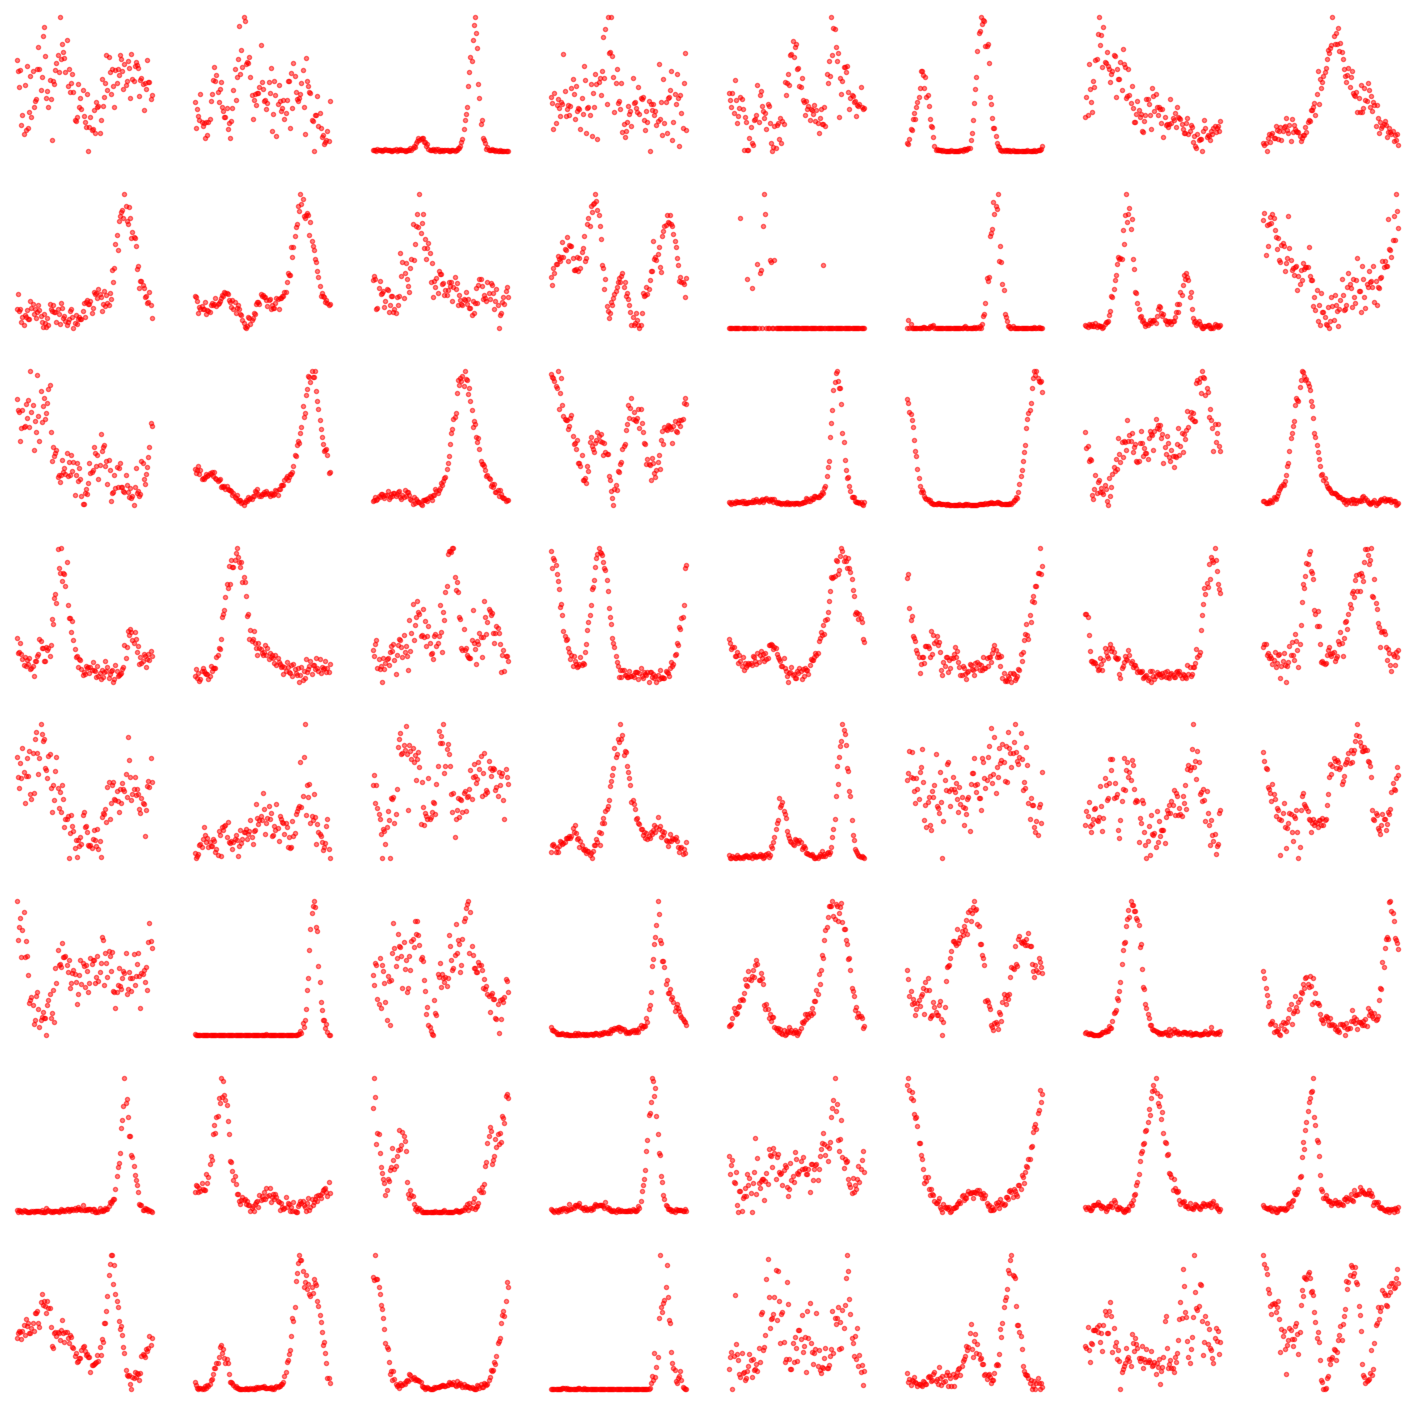

In [514]:


fig, axes = plt.subplots(8,8, figsize=(18,18), subplot_kw={'facecolor':'#ebf5ff'})

in_tune = 0
for i_ax in range(8):
    for j_ax in range(8):
        
        axes[i_ax, j_ax].scatter(tuning_curve_wake[l_cellids[in_tune]].axes[0].tolist(), tuning_curve_wake[l_cellids[in_tune]].tolist(), c='r', marker='.', plotnonfinite=True, alpha=0.5)
        # axes[i_ax, j_ax].scatter(tuning_curve_sleep[in_tune].axes[0].tolist(), tuning_curve_sleep[in_tune].tolist(), c='k', marker='.', plotnonfinite=True, alpha=0.5)
        axes[i_ax, j_ax].set_axis_off()
        in_tune += 1



In [248]:

def plot_tuning_curve(l_ind_epochs):

    fig = plt.figure(figsize=(18,18))

    h_plot = len(l_ind_epochs)
    gs = mpl.gridspec.GridSpec(10*h_plot,10*h_plot)

    # fig, axes = plt.subplots(10,10, figsize=(18,18), subplot_kw={'facecolor':'#ebf5ff'})

    number_of_colors = len(l_ind_epochs)

    color = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)])
             for i in range(number_of_colors)]

    for ind_iter,ind_epoch in enumerate(l_ind_epochs):

        sp_times_epoch = gen_sp_times_epoch(ind_epoch)    
        
        tuning_curve_wake = nap.compute_1d_tuning_curves(

            group = sp_times_epoch,
            feature=head_direction,
            nb_bins=120,
            minmax=(-np.pi, np.pi)
        )

        in_tune = 2
        for i_ax in range(10):
            for j_ax in range(10):
                in_tune += 1
                ax = fig.add_subplot(gs[i_ax*h_plot+ind_iter, j_ax:j_ax+h_plot])
                # ax.scatter(tuning_curve_wake[in_tune].axes[0].tolist(), tuning_curve_wake[in_tune].tolist(), c=color[ind_iter], marker='.', plotnonfinite=True, alpha=0.3)
                # axes[i_ax, j_ax].scatter(tuning_curve_sleep[in_tune].axes[0].tolist(), tuning_curve_sleep[in_tune].tolist(), c='k', marker='.', plotnonfinite=True, alpha=0.5)
                # ax.set_axis_off()
            
    plt.show()


In [517]:

def plot_tuning_curve(l_ind_epochs):

    fig, axes = plt.subplots(8,8, figsize=(18,18), subplot_kw={'facecolor':'#ebf5ff'})

    number_of_colors = len(l_ind_epochs)

    color = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)])
             for i in range(number_of_colors)]

    for ind_iter,ind_epoch in enumerate(l_ind_epochs):

        sp_times_epoch = gen_sp_times_epoch(ind_epoch)    
        
        tuning_curve_wake = nap.compute_1d_tuning_curves(

            group = sp_times_epoch,
            feature=head_direction,
            nb_bins=120,
            minmax=(-np.pi, np.pi)
        )

        in_tune = 0
        for i_ax in range(8):
            for j_ax in range(8):
              
                firing = (tuning_curve_wake[l_cellids[in_tune]]+ind_iter).tolist()
                axes[i_ax, j_ax].scatter(tuning_curve_wake[l_cellids[in_tune]].axes[0].tolist(), firing, s = 5, c=color[ind_iter], marker='.', plotnonfinite=True, alpha=0.8)
                axes[i_ax, j_ax].set_axis_off()
                in_tune += 1
            
    plt.show()


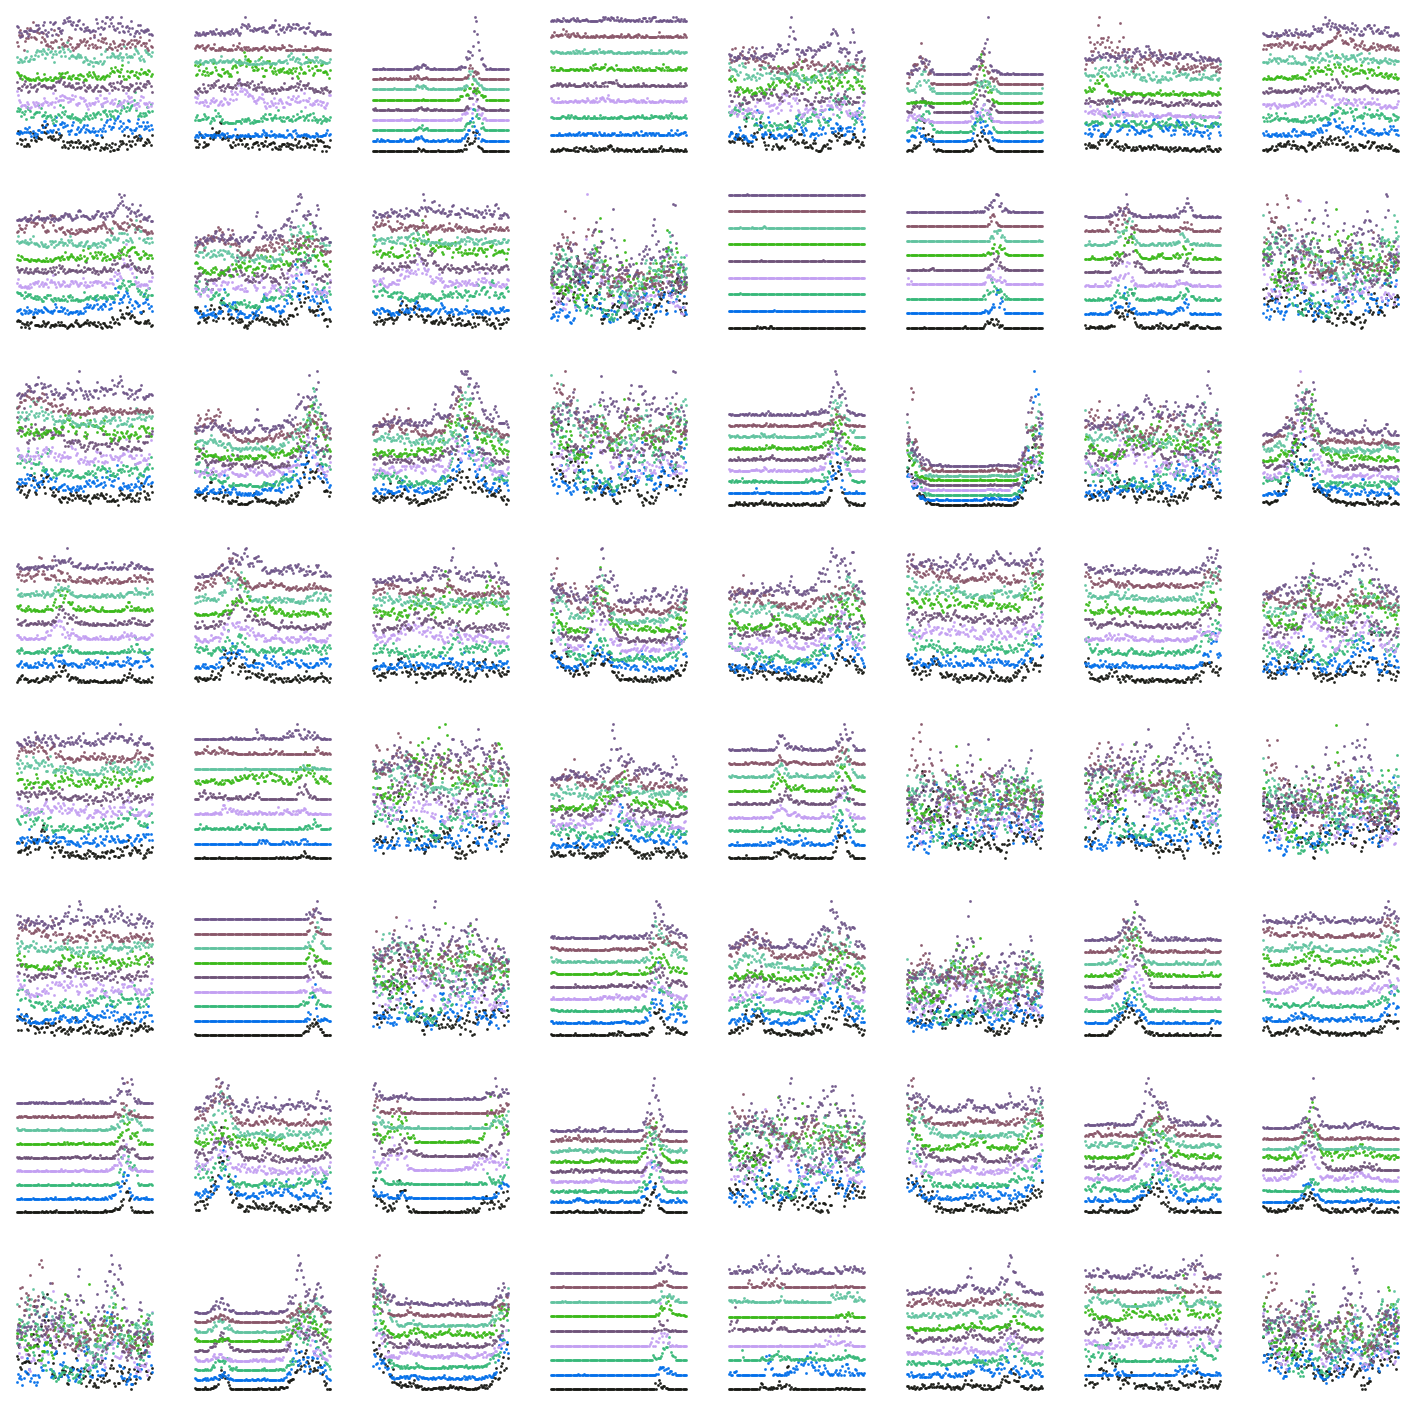

In [518]:
plot_tuning_curve(np.random.choice(9,9,replace=False))

In [ ]:

velocity['vel']

{'time_unit': {'t': 'time_units',
  'units': {'quantity': 'time', 'unit': 'ts', 'value': 1}},
 'data_unit': array([], dtype=uint8),
 't': array([ 3856.894,  3856.904,  3856.914, ..., 12637.5  , 12637.51 ,
        12637.52 ]),
 'data': array([3.87127125, 3.94324058, 3.87680473, ..., 7.28697429, 6.06404331,
        4.48291477]),
 'name': array([], dtype='<U1')}

(2000.0, 2010.0)

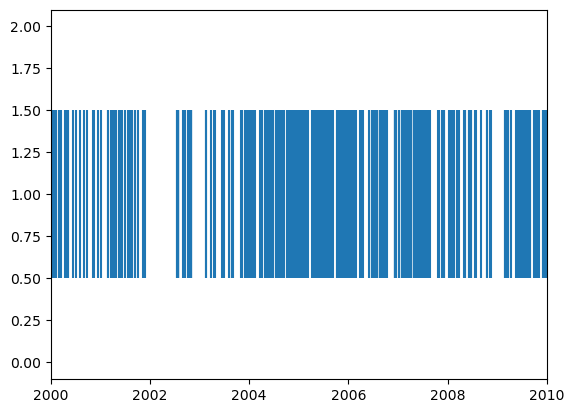

In [14]:
plt.eventplot(sp_times)
ax = plt.gca()
ax.set_xlim([2000,2010])